In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import cluster
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from skimage import color, morphology, filters

In [2]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def seg(img, kn=(15, 15), kp=(5, 5)):
    im_mean = ndimage.uniform_filter(img, kn)
    im_sqr_mean = ndimage.uniform_filter(img**2, kn)
    im_var = ndimage.minimum_filter(im_sqr_mean - im_mean**2, kp)
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    f = 0
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins = np.histogram(subset, bins=50)
        if min_bin == None or bins.max() < min_bin:
            min_bin = bins.max()
            f = bins[:-1][hist == hist.min()][-1]
    imth = im_var < f
    mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
    return mask

def seg_farid(img):
    img = filters.farid(img)
    for i in range(5):
        kn = (10+i, 10+i)
        im_mean = ndimage.uniform_filter(img, kn)
        im_sqr_mean = ndimage.uniform_filter(img**2, kn)
        im_var = ndimage.minimum_filter((im_sqr_mean - im_mean**2), (i, i))
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    f = 0
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins = np.histogram(subset, bins=50)
        if min_bin == None or bins.max() < min_bin:
            min_bin = bins.max()
            f = bins[:-1][hist == hist.min()][-1]
    imth = im_var < min_bin
    mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
    return mask

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = ypeaks[ymean[ypeaks] == ymean[ypeaks][np.isin(ymean[ypeaks], ymean[yfreqs < yfreqs[ymean == ymean[ypeaks].max()][0]])].max()]
    Px = xpeaks[xmean[xpeaks] == xmean[xpeaks][np.isin(xmean[xpeaks], xmean[xfreqs < xfreqs[xmean == xmean[xpeaks].max()][0]])].max()]
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

def predict_area(image):
    gray_image = color.rgb2gray(image)
    S = seg(gray_image)
    fx, fy = freq_peaks(gray_image)
    return np.sum(S)*fx*fy

def predict_area_with_farid(image):
    gray_image = color.rgb2gray(image)
    S = seg_farid(gray_image)
    fx, fy = freq_peaks(gray_image)
    return np.sum(S)*fx*fy

In [9]:
%%time
pdct, pdct_farid = [], []
for filename in DS.filename:
    image = get(filename)
    pdct.append(predict_area(image))
    pdct_farid.append(predict_area_with_farid(image))
DS['predict'] = pdct
DS['predict_farid'] = pdct_farid
DS

CPU times: total: 16min 31s
Wall time: 11min 57s


,filename,area,predict_farid,rel,predict
0,0.jpg,100.473,91.825058,8.611619,94.250443
1,1.jpg,127.880,117.158890,8.338982,119.237900
2,2.jpg,161.820,145.463699,10.107713,146.020660
3,3.jpg,190.003,171.914612,9.520054,169.490234
4,4.jpg,22.713,22.471100,0.894726,16.168671
...,...,...,...,...,...
350,350.jpg,98.599,99.445496,-0.858524,102.461243
351,351.jpg,98.599,99.724487,-1.141479,103.822754
352,352.jpg,98.599,99.321899,-0.723143,102.431580
353,353.jpg,98.599,99.691437,-1.074439,100.892273


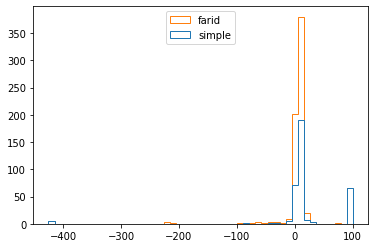

In [17]:
DS['rel'] = (DS.area - DS.predict)/DS.area*100
DS['farid_rel'] = (DS.area - DS.predict_farid)/DS.area*100
plt.hist(DS[['rel', 'farid_rel']].values, bins=50, histtype='step', stacked=True, fill=False, label=('simple', 'farid'))
plt.legend(loc='upper center')
plt.show()

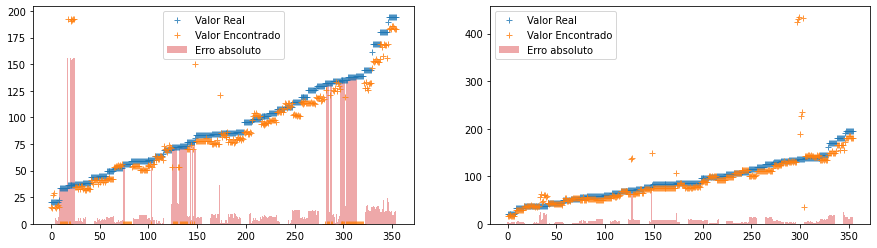

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
dss = DS.sort_values('area')

ax1.plot(dss.area.values, '+', alpha=0.8, label='Valor Real')
ax1.plot(dss.predict.values, '+', alpha=0.8, label='Valor Encontrado')
ax1.bar(np.arange(len(DS)), np.abs(dss.area.values - dss.predict.values), color='tab:red', alpha=0.4, label='Erro absoluto')

ax2.plot(dss.area.values, '+', alpha=0.8, label='Valor Real')
ax2.plot(dss.predict_farid.values, '+', alpha=0.8, label='Valor Encontrado')
ax2.bar(np.arange(len(DS)), np.abs(dss.area.values - dss.predict_farid.values), color='tab:red', alpha=0.4, label='Erro absoluto')

ax1.legend()
ax2.legend()
plt.show()

In [18]:
np.abs(DS[['rel', 'farid_rel']]).describe()

,rel,farid_rel
count,355.000000,355.000000
mean,32.393221,11.747866
std,62.793449,25.174633
min,0.136376,0.089464
25%,6.117146,3.043508
50%,8.935238,8.068441
75%,14.257172,10.807692
max,425.453250,221.154800
